In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from scipy import stats
import phik
import pyarrow.parquet as pq

import warnings
warnings.filterwarnings("ignore")

import matplotlib
min_val, max_val = 0, 0.8
n = 10
orig_cmap = plt.cm.summer
colors = orig_cmap(np.linspace(min_val, max_val, n))
custom_summer = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

# **1. Business Understanding**

New York City (NYC) sudah lama terkenal dengan moda transportasi taksinya. NYC Taxi & Limousine Commission (TLC) merupakan agensi pemerintahan setempat yang mengelola taksi di kota ini. Pada awalnya, hanya ada satu jenis taksi yang dikelola yaitu taksi kuning. Akan tetapi, seiring berjalannya waktu zona operasi taksi kuning menjadi terpusat di wilayah Manhattan, mengakibatkan kurangnya akses taksi secara legal dan aman di wilayah lainnya.

Untuk menangani permasalahan tersebut, di tahun 2013 NYC TLC membuat kebijakan baru dengan meluncurkan taksi berwarna hijau yang mempunyai batasan zona pickup, yaitu hanya bisa mengambil penumpang di luar pusat Manhattan. Meskipun taksi hijau ada untuk meningkatkan akses ke taksi di outer borough Manhattan, jumlah pickup taksi di wilayah ini tetap rendah ketika dibandingkan dengan jumlah pickup taksi kuning di wilayah yang sama.

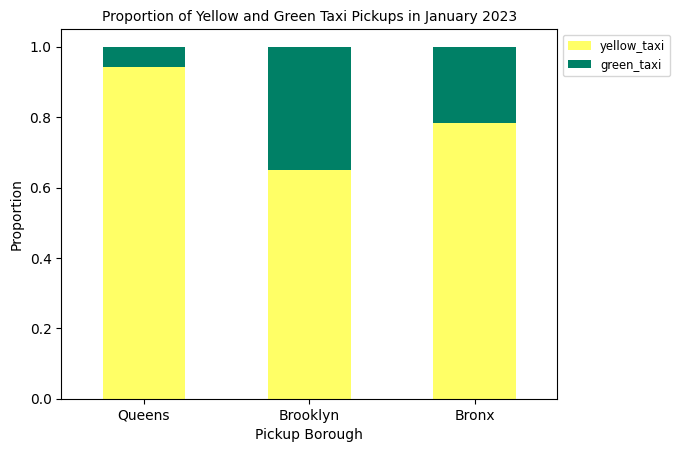

In [2]:
dfyel = pq.read_table('../data/processed/clean_yellow_taxi_sub.parquet').to_pandas()
dfyel = dfyel[(dfyel.trip_distance >= 0.2) & (dfyel.trip_duration_seconds >= 60) & (dfyel.fare_amount >= 3)]
dfgn = pd.read_csv('../data/processed/clean_nyc_tlc_trip_record.csv')
dfgn = dfgn[(dfgn.trip_distance >= 0.2) & (dfgn.trip_duration_seconds >= 60) & (dfgn.fare_amount >= 3)]

d1 = dfyel.pickup_borough.value_counts().reset_index()
d2 = dfgn[dfgn.isin(['Bronx', 'Brooklyn', 'Queens'])].pickup_borough.value_counts().reset_index()
d = d1.merge(d2, on='pickup_borough')
d.count_x, d.count_y = d.count_x/(d.count_x + d.count_y), d.count_y/(d.count_x + d.count_y)
d.rename(columns={'count_x': 'yellow_taxi', 'count_y': 'green_taxi'}, inplace=True)

plt.style.use('default')
ax = d.set_index('pickup_borough').plot(kind='bar', stacked=True, rot=0, colormap='summer_r')
ax.legend(bbox_to_anchor=(1.0, 1.0), fontsize='small')
ax.set_title(f'Proportion of Yellow and Green Taxi Pickups in January 2023', fontsize=10)
ax.set_xlabel('Pickup Borough')
ax.set_ylabel('Proportion')
plt.show;

## **1.1 Business Problem**

Agensi ingin **meningkatkan jumlah pickup taxi per jam di outer borough NYC** dengan **menganalisis karakteristik perjalanan taxi** di wilayah tersebut dan memperoleh rekomendasi solusi.

Berikut adalah beberapa turunan pertanyaan yang dapat membantu analisis:
1. Bagaimana proporsi pickup taksi berdasarkan wilayah di NYC?
2. Kapan peak-hour pickup taxi di weekday dan weekend?
3. Ke mana tujuan favorit penumpang yang berangkat dari outer borough NYC?
4. Berapa lama durasi perjalanan penumpang yang berangkat dari outer borough NYC?
5. Berapa jauh jarak tempuh perjalanan penumpang yang berangkat dari outer borough NYC?

# **2. Data Analysis**

In [3]:
df_clean = pd.read_csv('../data/processed/clean_nyc_tlc_trip_record.csv')
df_clean = df_clean.astype({
    'pickup_datetime': 'datetime64[s]',
    'dropoff_datetime': 'datetime64[s]'
})

Beberapa limitasi data yang digunakan pada analisis ini adalah:
- jarak tempuh >= 0.2 mil (jarak tempuh minimal agar taxi meter berjalan)
- durasi perjalanan >= 1 menit (durasi minimal agar taxi meter berjalan)
- fare amount >= $3 (tarif dasar ketika perjalanan dimulai)

Di luar batasan tersebut perjalanan taksi dianggap tidak valid.

In [4]:
# limitasi analisis: >=0.2mil & >=60s & >= 3$
tmp = len(df_clean[~((df_clean.trip_distance >= 0.2) & (df_clean.trip_duration_seconds >= 60) & (df_clean.fare_amount >= 3))])
df = df_clean[(df_clean.trip_distance >= 0.2) & (df_clean.trip_duration_seconds >= 60) & (df_clean.fare_amount >= 3)]

print(f'Jumlah data di luar batasan analisis: {tmp} atau {round(tmp/len(df_clean)*100, 2)}%' + "\n")
df.info()

Jumlah data di luar batasan analisis: 3627 atau 5.39%

<class 'pandas.core.frame.DataFrame'>
Index: 63688 entries, 0 to 67314
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype        
---  ------                  --------------  -----        
 0   pickup_datetime         63688 non-null  datetime64[s]
 1   dropoff_datetime        63688 non-null  datetime64[s]
 2   pickup_hour             63688 non-null  int64        
 3   pickup_day              63688 non-null  object       
 4   trip_duration_seconds   63688 non-null  int64        
 5   trip_duration_category  63688 non-null  object       
 6   trip_distance           63688 non-null  float64      
 7   trip_distance_category  63688 non-null  object       
 8   congestion_category     63688 non-null  object       
 9   fare_amount             63688 non-null  float64      
 10  fees                    63688 non-null  float64      
 11  tip_amount              63688 non-null  float64      
 12  total_amou

Data sudah melalui tahapan preparasi dan merupakan data bersih yang siap digunakan. Analisis akan dilakukan sesuai dengan pertanyaan yang sudah dirumuskan di atas, yaitu melihat karakteristik pickup taxi di outer borough NYC secara: proporsi jumlah pickup, waktu pickup (jam dan hari), tujuan perjalanan, jarak tempuh dan durasi perjalanan. Perlu diketahui bahwa NYC terbagi ke dalam 5 borough atau wilayah yaitu: Bronx, Brooklyn, Manhattan, Queens, dan Staten Island. Outer borough NYC mengacu pada wilayah selain Manhattan.

## **2.1 Demand per Borough**

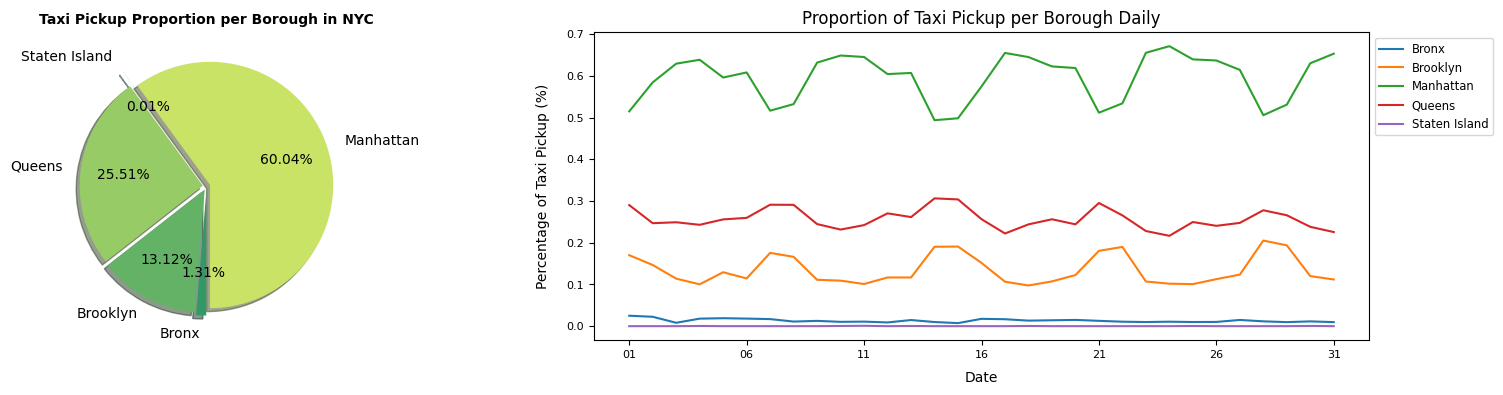

In [5]:
df_vc = df['pickup_borough'].value_counts().reset_index()
df_vc = df_vc.reindex([0, 4, 1, 2, 3])

#  set figure size
plt.style.use('default')
cmap = plt.get_cmap('summer')

fig, axes = plt.subplots(1,2)
# create pie chart
axes[0].pie(df_vc['count'], labels=df_vc['pickup_borough'], colors=cmap([200, 0, 150, 100, 50]), autopct='%0.2f%%', 
        startangle=270, pctdistance=0.65, labeldistance=1.15, explode=(0.03, 0.15, 0.03, 0.03, 0.05), shadow=True)

# set title
axes[0].set_title('Taxi Pickup Proportion per Borough in NYC', fontsize=10, weight='bold')

data = pd.crosstab(df.pickup_datetime.apply(lambda x: x.strftime('%d')), df.pickup_borough, normalize='index')

ax = data.plot(figsize=(20,4), rot=0, kind='line', ax=axes[1])
ax.legend(bbox_to_anchor=(1.0, 1.0), fontsize='small')
ax.tick_params(axis='both', labelsize=8)

plt.title(f'Proportion of Taxi Pickup per Borough Daily', fontsize=12)
plt.xlabel('Date', labelpad=8, fontsize=10)
plt.ylabel('Percentage of Taxi Pickup (%)', labelpad=12, fontsize=10)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=None)

plt.show();

In [6]:
data.describe()

pickup_borough,Bronx,Brooklyn,Manhattan,Queens,Staten Island
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.013281,0.134961,0.594926,0.256717,0.000115
std,0.004260,0.034956,0.056314,0.024115,0.000229
min,0.007290,0.097483,0.493558,0.216518,0.000000
25%,0.010062,0.108192,0.533025,0.242525,0.000000
50%,0.011573,0.116660,0.614104,0.249602,0.000000
75%,0.015813,0.168114,0.638853,0.268047,0.000000
max,0.025037,0.205155,0.670982,0.306244,0.000871


* Jumlah pickup taxi bisa dikatakan sebagai permintaan atau demand terhadap kebutuhan taxi di rentang waktu dan lokasi tertentu. Dari data selama 1 bulan pada bulan Januari 2023, persebaran demand taxi di wilayah atau borough New York City terlihat tidak merata. Dengan melihat pie chart di atas, ada satu wilayah yang mendominasi demand taxi yaitu Manhattan dimana proporsi pickup taxi selama satu bulan mencapai 60% dari keseluruhan pickup sementara wilayah Staten Island tidak mencapai angka 1%.

* Secara domain knowledge, ada faktor penentu lain yang memang menyebabkan ketimpangan demand taxi ini yaitu perbedaan jumlah populasi dan lokasi pusat bisnis. Manhattan merupakan wilayah dengan kepadatan populasi tertinggi di New York City dan merupakan sentra bisnis dan perkantoran, sehingga wajar jika mobilitas populasi dan kebutuhan penduduk untuk menggunakan transportasi lebih tinggi dibandingkan wilayah lainnya. Demand taxi per wilayah dapat dilihat lebih detil dengan melihat proporsi jumlah pickup taxi per harinya. Wilayah Manhattan mempunyai proporsi pickup taxi paling besar setiap harinya, dan nilai proporsi paling rendahnya hanya menyentuh angka 49.3%.

## **2.2 Demand per Hour & Day**

Analisis selanjutnya dilakukan untuk data dengan pickup di wilayah outer borough New York City yaitu Bronx, Brooklyn, dan Queens. Wilayah Staten Island tidak masuk cakupan analisis karena data pickup di wilayah ini hanya ada 8 poin data.

In [7]:
df = df[df.pickup_borough != 'Staten Island']
df_orig = df.copy()
df = df[df.pickup_borough.isin(['Bronx', 'Brooklyn', 'Queens'])]
print(f'Jumlah data: {len(df)}')

Jumlah data: 25440


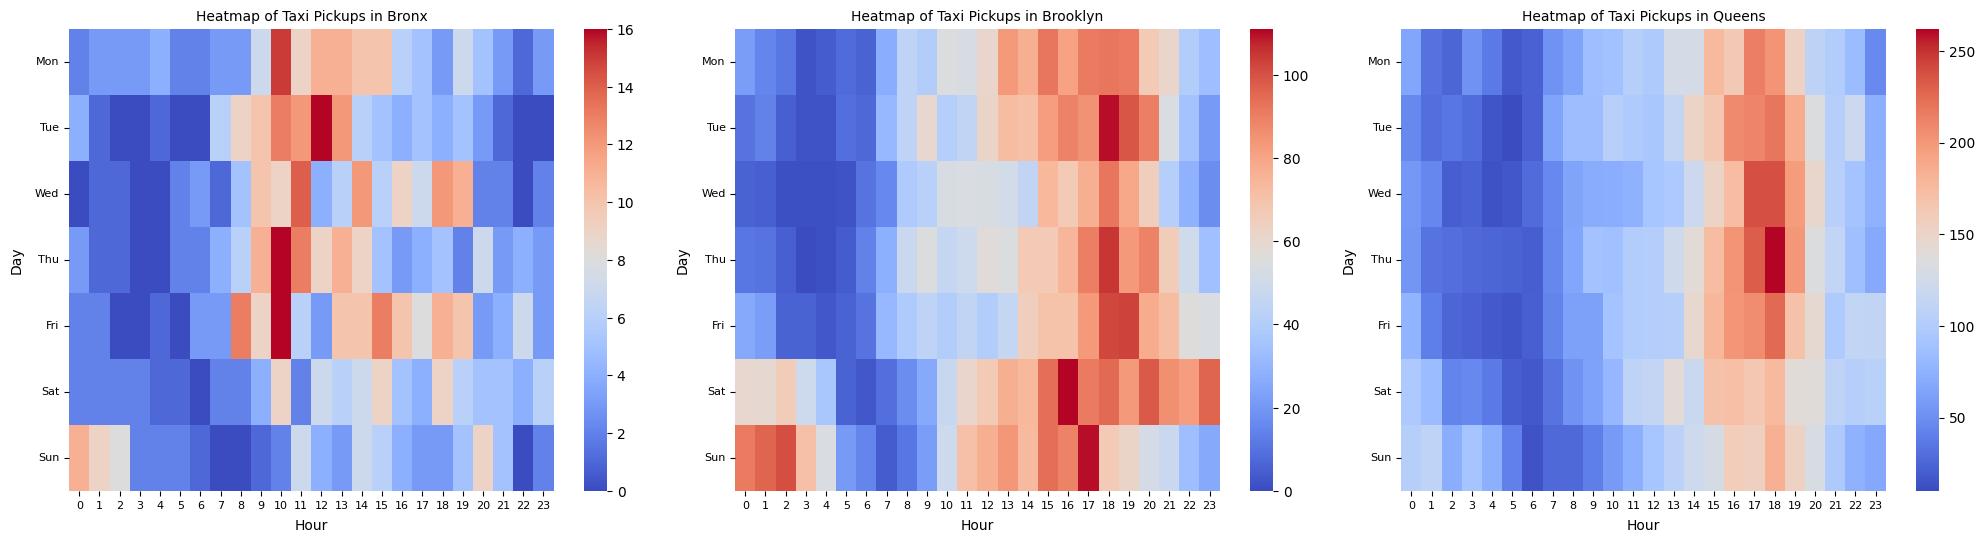

In [8]:
day_order = data = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun']
fig, axes = plt.subplots(1,3,figsize=(25,6))
for i, borough in enumerate(['Bronx', 'Brooklyn', 'Queens']):
    data = df[df.pickup_borough == borough]
    data = pd.crosstab(data.pickup_day, data.pickup_hour).reindex(day_order)

    ax = sns.heatmap(data, cmap='coolwarm', ax=axes[i])
    ax.set_title(f'Heatmap of Taxi Pickups in {borough}', fontsize=10)
    ax.set_xlabel('Hour', labelpad=6, fontsize=10)
    ax.set_ylabel('Day', labelpad=8, fontsize=10)
    ax.tick_params(axis='both', labelsize=8, labelrotation=0)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
plt.show()

* Ada waktu-waktu secara jam maupun hari yang merupakan peak-time pickup taxi atau waktu dimana jumlah pickup taxi lebih tinggi dibandingkan waktu lainnya. Interpretasi heatmap adalah semakin biru warna menandakan jumlah pickup per jam semakin rendah dan semakin merah warna berarti kebalikannya, jumlah pickup per jam semakin tinggi.
* Di wilayah Bronx, peak-hour pickup taksi terjadi pada hari kerja (Senin-Jumat) di sekitar jam 10 pagi sampai jam 12 siang. Off peak-hour hari kerja adalah di luar itu. Peak-hour pickup cenderung tidak terlihat di akhir pekan sehingga bisa dianggap sebagai off peak-time. 
* Di wilayah Brooklyn, peak-hour terlihat sepanjang pekan dari hari Senin sampai Minggu. Akan tetapi, jika pada hari kerja peak-hour adalah di sekitar jam pulang kantor yaitu jam 18-19, di akhir pekan peak-hournya sedikit lebih awal yaitu dari jam 15 sampai 23 untuk hari Sabtu, dan jam 15-17 untuk hari Minggu.
* Di wilayah Queens, peak-hour ada pada hari kerja juga di sekitar jam pulang kantor yaitu jam 18. Di akhir pekan cenderung tidak ada peak-hour, meskipun ada peningkatan pickup taxi di jam 15-19.
* Dari heatmap di atas kembali terlihat bahwa ada ketimpangan jumlah pickup taxi per jam antar wilayah, dimana wilayah Bronx per jamnya hanya mencapai 16 pickup sementara di wilayah Queens bisa mencapai hingga 250 pickup per jam. Hal ini mempengaruhi deteksi peak-hour karena peak-hour cenderung lebih terlihat ketika jumlah poin data lebih banyak.

## **2.3 Dropoff Borough, Trip Distance, Trip Duration**

Karakteristik perjalanan yang selanjutnya dilihat adalah tujuan wilayah, kategori jarak tempuh (short <= 5 mil, long > 5 mil), kategori durasi perjalanan (short <= 15 menit, long > 15 menit) di tiga wilayah outer borough NYC.

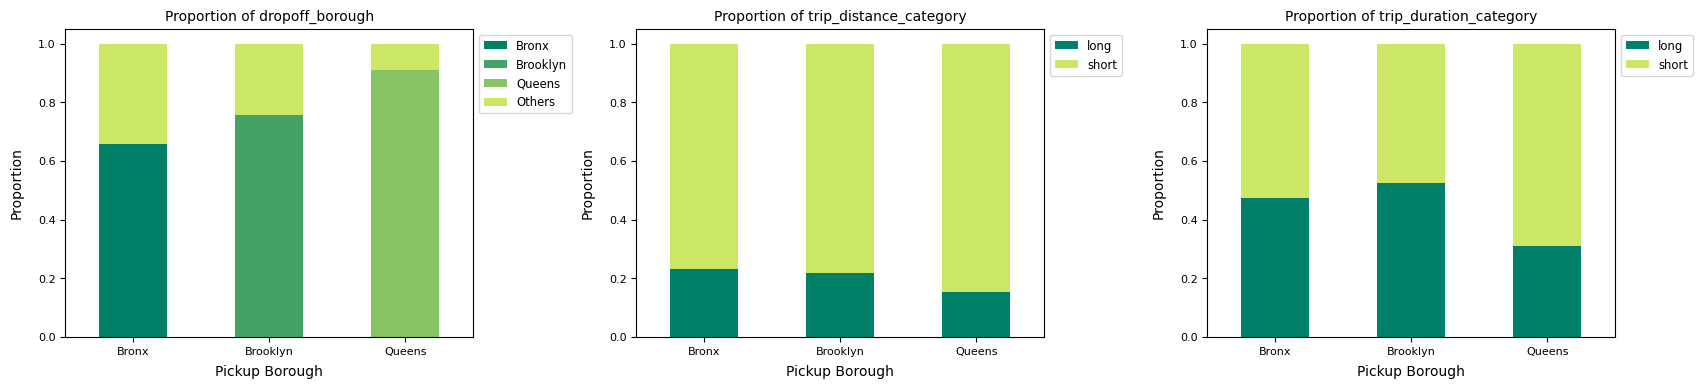

In [9]:
fig, axes = plt.subplots(1,3,figsize=(20,4))
for i, col in enumerate(['dropoff_borough', 'trip_distance_category', 'trip_duration_category']):
    data = pd.crosstab(df['pickup_borough'], df[col], normalize='index')

    if col == 'dropoff_borough':
        for borough in data.index.values:
            data.loc[borough, 'Others'] = data.loc[borough, data.columns!= borough].sum()
            data.loc[borough, ~data.columns.isin([borough, 'Others'])] = 0
        data = data[['Bronx', 'Brooklyn', 'Queens', 'Others']]

    plt.style.use('default')
    ax = data.plot(colormap=custom_summer, kind='bar', stacked=True, ylabel=False, fontsize=9, ax=axes[i], rot=0)
    ax.legend(bbox_to_anchor=(1.0, 1.0), fontsize='small')
    
    ax.tick_params(axis='both', labelsize=8)
    ax.set_title(f'Proportion of {col}', fontsize=10)
    ax.set_xlabel('Pickup Borough', labelpad=6, fontsize=10)
    ax.set_ylabel('Proportion', labelpad=10, fontsize=10)

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)

plt.show();

* Secara tujuan wilayah, kita dapat melihat bahwa penumpang lebih banyak melakukan perjalanan di dalam wilayah asalnya atau dengan tujuan di wilayah yang sama juga (misal dari wilayah Bronx ke Bronx atau perjalanan di dalam wilayah Brooklyn saja).
* Secara jarak tempuh, perjalanan taksi jarak pendek (atau < 5 mil) mempunyai proporsi yang lebih besar dibandingkan perjalanan jarak jauh (> 5 mil). Dapat disimpulkan bahwa pada dasarnya penumpang menggunakan taksi untuk jarak tempuh yang dekat saja.
* Secara durasi perjalanan, masing-masing wilayah mempunyai karakteristik yang berbeda. Di Bronx, proporsi perjalanan dengan waktu singkat (atau < 15 menit) cenderung sama dengan perjalanan waktu lama. Di Brooklyn, proporsi perjalanan dengan waktu singkat sedikit lebih kecil daripada perjalanan waktu lama. Di Queens, proporsi perjalanan dengan waktu singkat lebih besar dari perjalanan waktu lama.

Karakteristik jarak tempuh dan durasi perjalanan secara numerik (bukan kategorikal) di setiap wilayah akan dilihat lebih detil dari jam pickupnya.

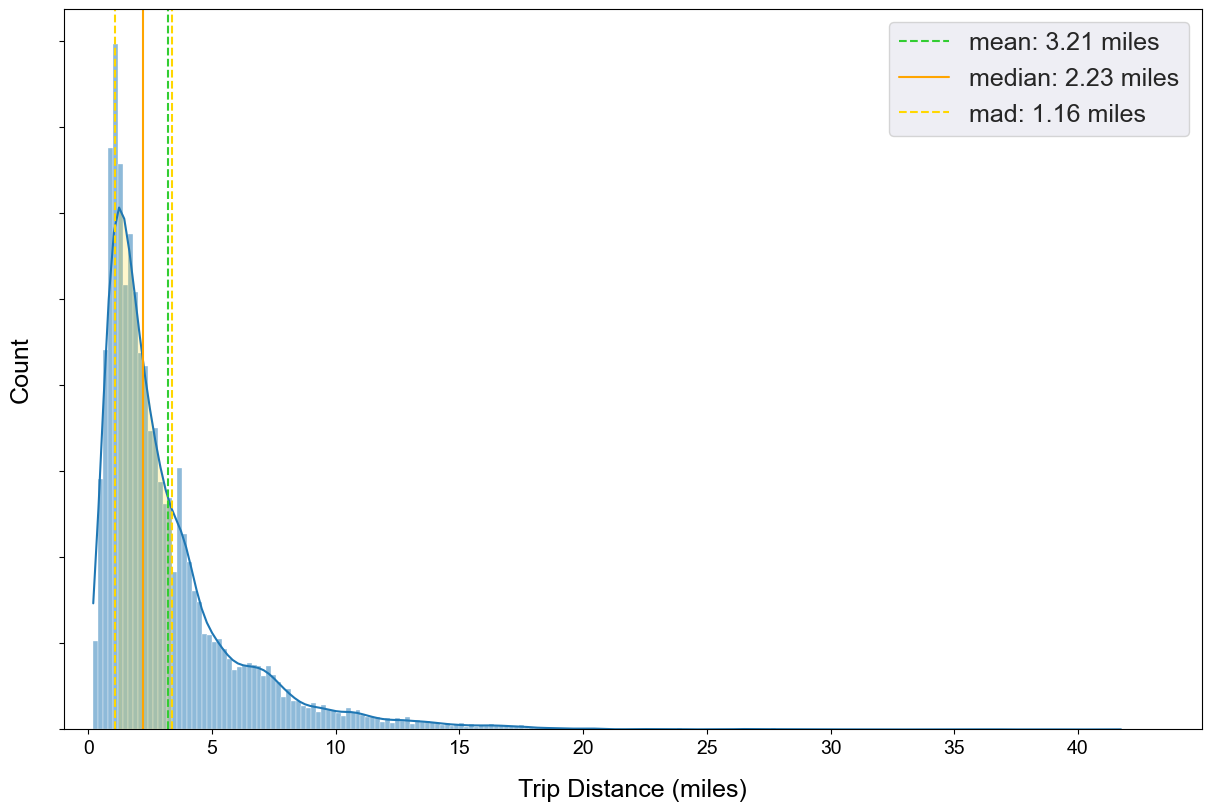

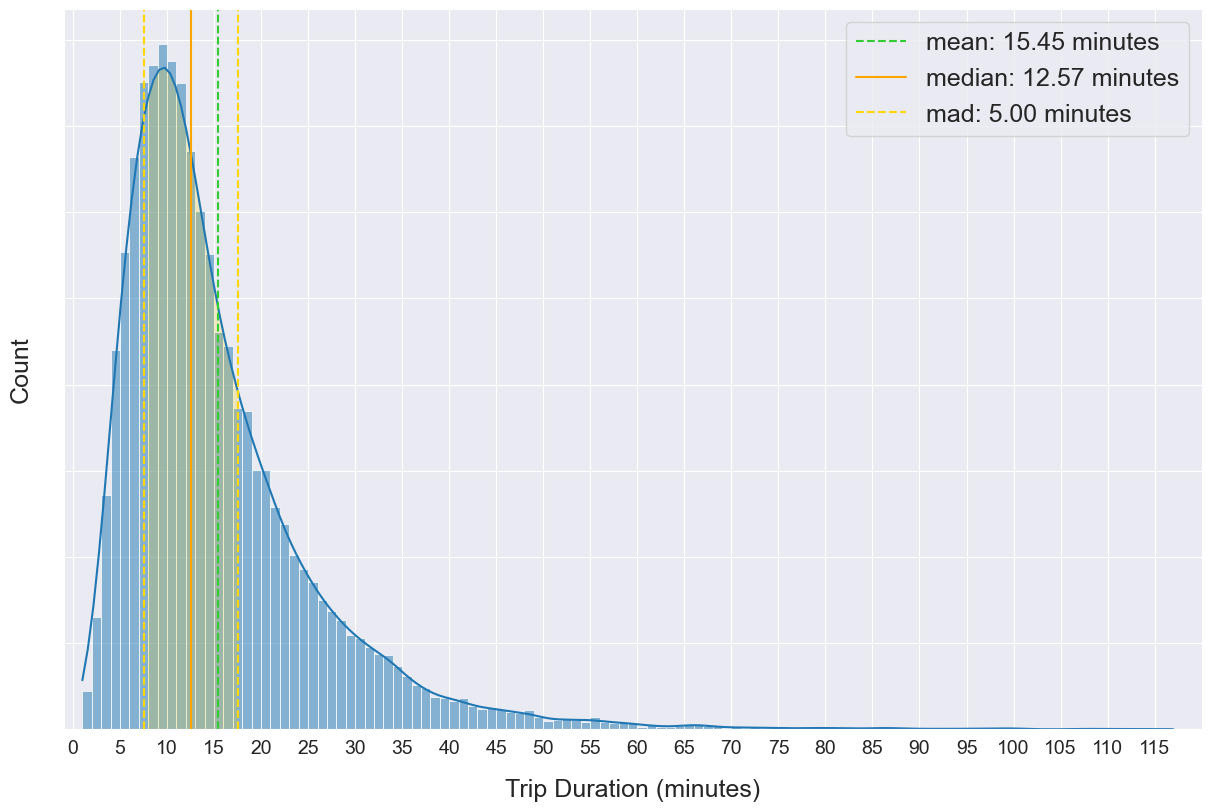

In [10]:
def distplot(data, bins, xticks, xlim, xlabel, unit, column=None):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(12,8),
        constrained_layout=True
    )
    sns.set_style("darkgrid")

    if column:
        sns.histplot(data=data, x=column, bins=bins, kde=True, ax=axes)
        # calculate central tendencies
        mean = data[column].mean()
        median = data[column].median()
        mad = abs(data[column] - data[column].median()).median()
    else:
        sns.histplot(data=data, bins=bins, kde=True, ax=axes)
        # calculate central tendencies
        mean = data.mean()
        median = data.median()
        mad = abs(data - data.median()).median()
    
    # create tendencies measurement lines
    axes.axvline(x=mean, color="limegreen", linestyle="--", label=f"mean: {mean:.2f} {unit}")
    axes.axvline(x=median, color="orange", linestyle="-", label=f"median: {median:.2f} {unit}")
    axes.axvline(x=median + mad, color="gold", linestyle="--", label=f"mad: {mad:.2f} {unit}")
    axes.axvline(x=median - mad, color="gold", linestyle="--")
    kde_x_0, kde_y_0 = axes.lines[0].get_data()
    axes.fill_between(
        kde_x_0, 
        kde_y_0, 
        where=(kde_x_0 > median - mad) & (kde_x_0 < median + mad), 
        color='gold', 
        alpha=0.2
    )

    axes.legend(prop={'size': 18})
    axes.set_xlim(xlim[0], xlim[1])

    axes.set_xlabel(xlabel, labelpad=15, fontsize=18)
    axes.set_xticks(xticks)
    axes.set_ylabel("Count", labelpad=15, fontsize=18)

    axes.tick_params(axis='both', labelsize=14)
    axes.tick_params(axis='x', labelsize=14)
    axes.set(yticklabels=[])

    plt.show();

distplot(data=df, column='trip_distance', bins=np.arange(0,50,0.2),
            xticks=np.arange(0,45,5), xlim=[-1,45], xlabel='Trip Distance (miles)', unit='miles')
distplot(data=df.trip_duration_seconds.apply(lambda x: x/60), bins=np.arange(0,120,1),
            xticks=np.arange(0,120,5), xlim=[-1,120], xlabel='Trip Duration (minutes)', unit='minutes')

* Secara grafik, terlihat bahwa kedua variabel memiliki distribusi tidak normal (condong ke kanan). Ukuran pemusatan yang akan digunakan adalah median.

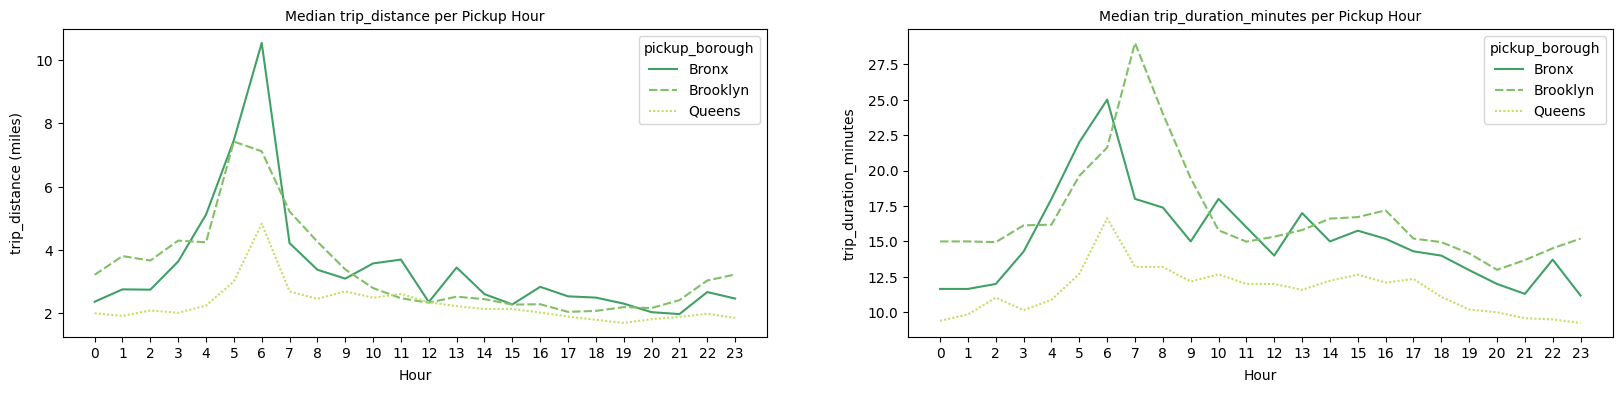

In [11]:
df['trip_duration_minutes'] = df.trip_duration_seconds.apply(lambda x: x/60)
plt.style.use('default')
fig, axes = plt.subplots(1,2,figsize=(20,4))
for i, col in enumerate(['trip_distance', 'trip_duration_minutes']):
    data = df.pivot_table(
        columns=['pickup_borough'],
        values=[col],
        index=['pickup_hour'],
        aggfunc='median')
    data = data.xs(col, axis=1, drop_level=True)
    ax = sns.lineplot(data, palette='summer', ax=axes[i])
    ax.set_title(f'Median {col} per Pickup Hour', fontsize=10)
    ax.set_xlabel('Hour', labelpad=6, fontsize=10)
    if i == 0: ax.set_ylabel(f'{col} (miles)', labelpad=8, fontsize=10)
    else: ax.set_ylabel(f'{col}', labelpad=8, fontsize=10)    
    ax.set_xticks(np.arange(0,24))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
plt.show();

* Jarak tempuh dan durasi perjalanan juga memiliki peak-time di masing-masing outer borough NYC. 
* Peak-time untuk jarak tempuh terjadi di sekitar jam 6 pagi atau di sekitar jam berangkat kerja orang kantoran. Tetapi selain periode peak-time, median dari jarak tempuh di setiap wilayah adalah kurang dari 5 mil sesuai dengan hasil temuan sebelumnya, dimana proporsi perjalanan jarak pendek lebih besar.
* Peak-time untuk durasi perjalanan mempunyai rentang jam yang lebih lebar dibandingkan peak-time jarak tempuh, yaitu mulai dari jam 4 hingga jam 7-8 pagi. Sama seperti poin sebelumnya, rentang waktu ini merupakan rentang jam berangkat atau masuk kerja.

# `Conclusion`
1. Bagaimana proporsi perjalanan taksi berdasarkan wilayah di NYC? <br>
Proporsi pickup taxi pada masing-masing wilayah di NYC tidak merata. Wilayah Manhattan mendominasi jumlah pickup taxi dengan proporsi mencapai 60% sementara di wilayah Staten Island hanya sebesar 0.02%.

2. Kapan peak-hour pickup taxi di weekday dan weekend? <br>
Peak-hour pickup taxi di wilayah outer borough NYC secara umum berbeda saat weekday dan weekend. Di weekday, pickup taxi kebanyakan terjadi di jam pulang kantor yaitu jam 18. Sementara di weekend, peak-hour pickup taxi sedikit lebih awal yaitu dari jam 15-16.

3. Ke mana tujuan favorit penumpang yang berangkat dari outer borough New York City? <br>
Proporsi perjalanan dengan tujuan wilayah yang sama dengan wilayah asal lebih banyak daripada perjalanan lintas wilayah. Sebagai contoh, di wilayah Brooklyn tujuan wilayah paling banyak juga berada di Brooklyn.

4. Berapa lama durasi perjalanan penumpang yang berangkat dari outer borough New York City? <br>
Proporsi perjalanan jarak singkat lebih banyak daripada perjalanan jarak jauh. Saat melihat durasi perjalanan per jam pickup, terlihat ada peak-hour untuk median durasi perjalanan, tertinggi dicapai di sekitar jam 6-8 pagi.

5. Berapa jauh jarak tempuh perjalanan penumpang yang berangkat dari outer borough New York? <br>
Karakteristik jarak tempuh perjalanan berbeda-beda di setiap wilayahnya. Ada wilayah dengan proporsi perjalanan jarak singkat lebih besar, cenderung sama, dan lebih kecil dari proporsi perjalanan jarak jauh. Sama seperti durasi perjalanan, terdapat peak-hour untuk median jarak perjalanan yaitu di sekitar jam 6 pagi.

# `Recommendation`

* Melakukan strategi marketing dengan sasaran populasi di outer Borough sesuai dengan karakteristik penumpang yang telah dianalisis
    - Melakukan promosi saat: off-peak hour secara umum, tujuan perjalanan lintas wilayah atau dengan kata lain ada diskon tarif ketika jarak tempuh lebih lama. Selain itu, juga bisa bisa mempertimbangkan kategori jarak tempuh atau durasi perjalanan saat peak-hour dan off peak-hour.
* Melakukan evaluasi zona operasi Green dan Yellow Taxi
    - Yellow Taxi tidak mempunyai batasan zona operasi sementara Green Taxi secara aturan tidak dibolehkan untuk mengambil penumpang di pusat Manhattan. Salah satu akibat dari peraturan ini adalah menimbulkan keengganan sopir untuk melakukan perjalanan dengan tujuan pusat Manhattan karena kemungkinan untuk mendapatkan penumpang saat perjalanan pulang lebih kecil (jika mematuhi peraturan).